In [1]:
from laserscan import *

925
75


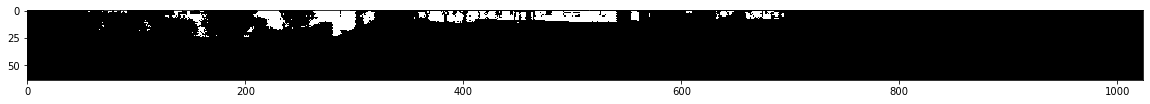

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from laserscan import *

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device = "cuda:0"
from torch.utils.data import Dataset, DataLoader
class CustomKitti(Dataset):
    def __init__(self, dir, mode="train"):
        self.ls = SemLaserScan(project=True, nclasses=100)
        self.mode = mode
        self.len = 4541
        self.train_len = 3700
        self.val_len = 300
        self.test_len = self.len - self.train_len - self.val_len
        self.label_folder = dir + "plane_labels/"
        self.file_folder = dir + "velodyne/"
    def __len__(self):
        if self.mode == "train":
            return self.train_len
        if self.mode == "val":
            return self.val_len
        return self.test_len
    def __getitem__(self, idx):
        if self.mode == "test":
            idx += self.train_len + self.val_len
        if self.mode == "val":
            idx += self.train_len
        self.ls.open_scan(self.file_folder + '{0:06d}.bin'.format(idx))
        self.ls.open_label(self.label_folder + 'label-{0:06d}.npy'.format(idx))
        self.ls.proj_sem_label[self.ls.proj_sem_label != 0] = 1
        return np.dstack((self.ls.proj_xyz, self.ls.proj_remission, self.ls.proj_range)), self.ls.proj_sem_label

training_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/") 
validation_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/", mode="val") 
test_data = CustomKitti("/home/polosatik/mnt/kitty/dataset/sequences/00/", mode="test") 

batch_size = 4

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(len(training_loader))
print(len(validation_loader))

vinputs, vlabels = next(iter(test_loader))
plt.figure(figsize=(20,80))
plt.imshow(vlabels[0], cmap="gray")
# validation_data.__len__()

In [3]:
from torch import Tensor
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [4]:
max_classes = 2
from unet import UNet
from torch import nn
import torch.nn.functional as F
def get_model_and_optimizer(device, num_encoding_blocks=5, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    unet = UNet(
          in_channels=5,
          out_classes=max_classes,
          dimensions=2,
          num_encoding_blocks=num_encoding_blocks,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='ReLU',
      ).to(device)
    model = unet
      
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

In [5]:
criterion = nn.CrossEntropyLoss()
def train_one_epoch(epoch_index, tb_writer, optimizer, model):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = torch.tensor(inputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
        labels = torch.tensor(labels).to(device=device, dtype=torch.long)
        # print(torch.max(labels))
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        print(outputs.shape, labels.shape)
        # Compute the loss and its gradients
        # loss = torch.nn.functional.mse_loss(outputs.squeeze(), labels)
        loss = criterion(outputs, labels) + dice_loss(F.softmax(outputs, dim=1).float(),
                                       F.one_hot(labels, max_classes).permute(0, 3, 1, 2).float(),
                                       multiclass=True)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100== 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # tb_writer.add_image("label", visualize_seg(labels.numpy(), mc).squeeze()[0], 0)
            # tb_writer.add_image("label", visualize_seg(outputs.cpu().numpy(), mc).squeeze()[0], 0)

            running_loss = 0.

    return last_loss

In [6]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# run_name = "SEMANTIC_log softmax_nll_"
run_name = "SEMANTIC_cross_entropy_dice_softmax_5 s"
writer = SummaryWriter('runs/{}_{}'.format(run_name, timestamp))
epoch_number = 0

EPOCHS = 40

best_vloss = 1_000_00000.
model, optimizer, scheduler = get_model_and_optimizer(device)

In [ ]:
train = True
if train :
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, optimizer, model)

        with torch.no_grad():
        # We don't need gradients on to do reporting
            model.train(False)

            running_vloss = 0.0
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
                vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.long)

                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels) + dice_loss(F.softmax(voutputs, dim=1).float(),
                                        F.one_hot(vlabels, max_classes).permute(0, 3, 1, 2).float(),
                                        multiclass=True)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'chpt/model_{}_{}_{}'.format(run_name, timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

torch.Size([4, 64, 1024]) torch.Size([4, 64, 1024, 5])
(64, 1024, 2)


/tmp/ipykernel_14367/1438848842.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
/tmp/ipykernel_14367/1438848842.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.float)


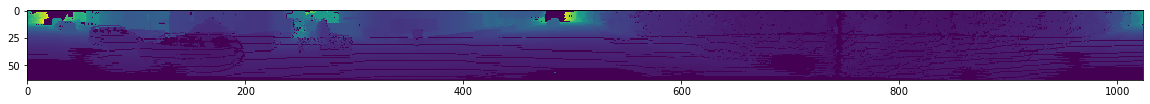

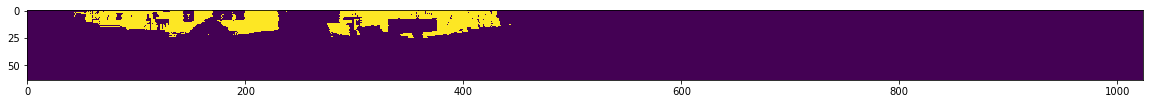

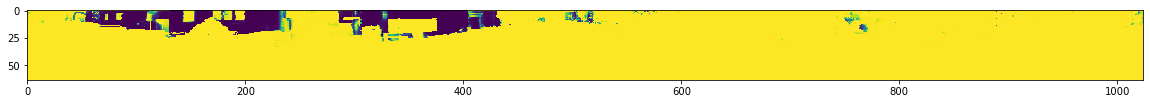

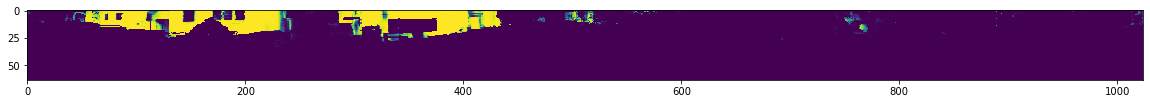

In [ ]:
model.load_state_dict(torch.load("chpt/model_SEMANTIC_cross_entropy_dice_softmax_5 s_20221117_084853_20"))
model.train(False)
model.to(device)
vinputs, vlabels = next(iter(test_loader))
plt.figure(figsize=(20,80))
plt.imshow(vinputs[0][:,:, 4])
plt.figure(figsize=(20,80))
plt.imshow(vlabels[0])

print(vlabels.shape, vinputs.shape)
vinputs = torch.tensor(vinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
vlabels = torch.tensor(vlabels).to(device=device, dtype=torch.float)
# 201
voutputs = model(vinputs)
print(voutputs[0].cpu().permute(1,2,0).detach().numpy().squeeze().shape)
plt.figure(figsize=(20,80))
plt.imshow(F.softmax(voutputs, dim=1)[0].cpu().permute(1,2,0).detach().numpy().squeeze()[:,:, 0])
plt.figure(figsize=(20,80))
plt.imshow(F.softmax(voutputs, dim=1)[0].cpu().permute(1,2,0).detach().numpy().squeeze()[:,:, 1])

In [ ]:
from torchmetrics import JaccardIndex
import metrics

jaccard = JaccardIndex(num_classes=2)
pred = F.softmax(voutputs, dim=1)[0].permute(1,2,0).detach().squeeze()[:,:, 1]
vlabels.shape
print(jaccard(pred.cpu(), vlabels[0].int().cpu()))
metric_calculator = metrics.SegmentationMetrics(average=True, ignore_background=True, activation="softmax")
print(vlabels[0].int().shape, voutputs[0].shape)
metric_calculator(vlabels.int(), voutputs)
# pred
# F.softmax(voutputs, dim=1)[0].cpu().permute(1,2,0).detach().numpy().squeeze()[:,:, 1]


tensor(0.9061)
torch.Size([64, 1024]) torch.Size([2, 64, 1024])


(0.9218953322843892, 0.9256186629880894, 0.92189533192352, 0.9293721914617133)

In [ ]:
model.train(False)
model.to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
jaccard = JaccardIndex(num_classes=2)
mIoU = 0
Precision = 0
Recall = 0 
Dice = 0
Pixel_accuracy = 0 
time = 0
metric_calculator = metrics.SegmentationMetrics(average=True, ignore_background=True, activation="softmax")
with torch.no_grad():
    for i, data in enumerate(test_loader):
        tinputs, tlabels = data
        tinputs = torch.tensor(tinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
        tlabels = torch.tensor(tlabels).to(device=device, dtype=torch.long)

        # Make predictions for this batch
        starter.record()
        toutputs = model(tinputs)
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        batch_iou = 0
        for i in range(len(toutputs)):
            pred = F.softmax(toutputs, dim=1)[i].permute(1,2,0)[:,:, 1]
            batch_iou += jaccard(pred.cpu(), tlabels[i].cpu().int())
        mIoU += batch_iou/batch_size
        time += curr_time
        pixel_accuracy, dice, precision, recall = metric_calculator(tlabels.int(), toutputs)
        Pixel_accuracy += pixel_accuracy
        Dice += dice
        Recall += recall
        Precision += precision
        print("inference: {0}, batch_iou: {1}, precision: {2}, recall: {3}, dice: {4}, acc: {5}".format(curr_time, batch_iou/batch_size, precision, recall, dice, pixel_accuracy))
mIoU /= len(test_loader)
mTime = time / len(test_loader)
Precision /= len(test_loader)
Dice /= len(test_loader)
Recall /= len(test_loader)
Pixel_accuracy /= len(test_loader)
# print("mean inference: {0}, mean iou: {1}".format( mTime, mIoU))
print("MEAN inference: {0}, batch_iou: {1}, precision: {2}, recall: {3}, dice: {4}, acc: {5}".format(mTime, mIoU, Precision, Recall, Dice, Pixel_accuracy))



/tmp/ipykernel_14367/1610888461.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tinputs = torch.tensor(tinputs).permute(0,3,1,2).to(device=device, dtype=torch.float)
/tmp/ipykernel_14367/1610888461.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlabels = torch.tensor(tlabels).to(device=device, dtype=torch.long)


inference: 64.68943786621094, batch_iou: 0.8447953462600708, precision: 0.7793742083436951, recall: 0.8479480097156241, dice: 0.8122162917723272, acc: 0.7793742088654328
inference: 59.759742736816406, batch_iou: 0.8830991983413696, precision: 0.847964815312653, recall: 0.8930762186791857, dice: 0.8699360853724435, acc: 0.8479648159053155
inference: 58.6673583984375, batch_iou: 0.9214291572570801, precision: 0.9258089691020912, recall: 0.9449404892353417, dice: 0.935276903374103, acc: 0.9258089694196798
inference: 56.51443099975586, batch_iou: 0.8905607461929321, precision: 0.904352996881189, recall: 0.9082917699426406, dice: 0.9063181040228906, acc: 0.9043529973648238
inference: 56.59910583496094, batch_iou: 0.905887246131897, precision: 0.8841247129011479, recall: 0.927893137910955, dice: 0.905480322684691, acc: 0.8841247134371755
inference: 56.567134857177734, batch_iou: 0.7872521281242371, precision: 0.553210848388902, recall: 0.8677899469837331, dice: 0.6756798649185617, acc: 0.553